#**FA5 Multivariate ANOVA**

2021059121 | Bayquen, Christopher Gilbert A.


In [46]:
import pandas as pd
import numpy as np
import pingouin as pg
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA
from scipy.spatial.distance import euclidean
from skbio.stats.distance import permanova, DistanceMatrix

In [5]:

 #loading the dataset

employee_df = pd.read_csv("/content/drive/MyDrive/employee_attrition_train.csv")
employee_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,50.0,No,Travel_Rarely,1126.0,Research & Development,1.0,2,Medical,1,997,...,3,80,1,32,1,2,5,4,1,3
1,36.0,No,Travel_Rarely,216.0,Research & Development,6.0,2,Medical,1,178,...,4,80,2,7,0,3,3,2,0,1
2,21.0,Yes,Travel_Rarely,337.0,Sales,7.0,1,Marketing,1,1780,...,2,80,0,1,3,3,1,0,1,0
3,50.0,No,Travel_Frequently,1246.0,Human Resources,NaN,3,Medical,1,644,...,3,80,1,32,2,3,32,5,10,7
4,52.0,No,Travel_Rarely,994.0,Research & Development,7.0,4,Life Sciences,1,1118,...,4,80,0,18,4,3,8,6,4,0


In [8]:
# Select relevant columns for the analysis
employee_df = employee_df[['JobSatisfaction', 'Age', 'DailyRate', 'MonthlyIncome']].dropna()
employee_df['JobSatisfaction'] = employee_df['JobSatisfaction'].astype('category')
employee_df.head()

,JobSatisfaction,Age,DailyRate,MonthlyIncome
0,4,50.0,1126.0,17399
1,2,36.0,216.0,4941
2,2,21.0,337.0,2679
3,2,50.0,1246.0,18200
4,2,52.0,994.0,10445


**Context on the data**

Attracting and retaining top talent is essential for an organization’s success. This dataset, created for an HR analysis, aims to identify the factors that influence employee retention and attrition. By understanding the elements that encourage employees to stay or prompt them to leave, the organization seeks insights to inform strategies for reducing turnover. Watson Analytics has been employed to support this analysis. The dataset contains information on both past and current employees, with various data points captured. It particularly focuses on whether employees are still with the company or have left, aiming to analyze how these factors correlate with workforce attrition.

**Checking for MANOVA Assumptions**


**1. Independence Assumption** - *observations must be statistically independent.*

There is no significant relationship between any of the observations between each group of the variables. There are no repeated measures for each employee.


**2. Level and Measurement of Variables Assumption** - *the independent variables are categorical and the dependent variables are continuous or scale variables*

In the provided data set, the dependent variables `age, daily rate, and monthly income` are all numerical variables, while the independent variable ` job satisfaction levels` is categorical. This assumption is met.

**3. Multicollinearity Assumption** - *that there is no high degree of multicollinearity among the dependent variables.*

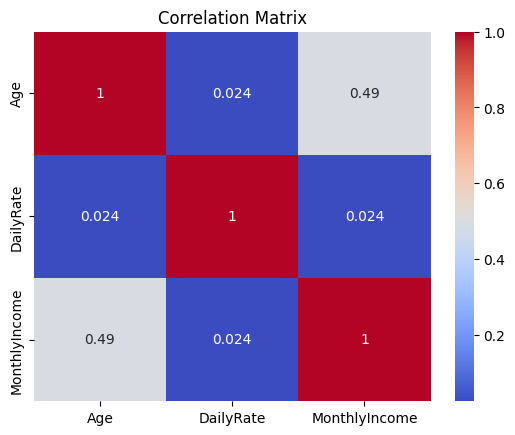

In [9]:
# Correlation matrix for dependent variables
correlation_matrix = employee_df[['Age', 'DailyRate', 'MonthlyIncome']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


The correlation values among `Age, DailyRate, and MonthlyIncome` are all well below 0.8, which suggests that multicollinearity is **not a concern**.

**4. Normality Assumption** -*The data within each group follows a normal distribution.*


In [19]:
#Using the Shapiro-Wilk test to check for normality

job_satisfaction_levels = employee_df['JobSatisfaction'].unique()
for level in job_satisfaction_levels:
    print(f"Shapiro-Wilk test for JobSatisfaction level {level}:")
    for variable in ['Age', 'DailyRate', 'MonthlyIncome']:
        stat, p = stats.shapiro(employee_df[employee_df['JobSatisfaction'] == level][variable])
        print(f"  {variable}: Statistic = {stat:.3f}, p-value = {p:.3f}")
    print("\n")

Shapiro-Wilk test for JobSatisfaction level 4:
  Age: Statistic = 0.975, p-value = 0.000
  DailyRate: Statistic = 0.959, p-value = 0.000
  MonthlyIncome: Statistic = 0.851, p-value = 0.000


Shapiro-Wilk test for JobSatisfaction level 2:
  Age: Statistic = 0.978, p-value = 0.004
  DailyRate: Statistic = 0.935, p-value = 0.000
  MonthlyIncome: Statistic = 0.828, p-value = 0.000


Shapiro-Wilk test for JobSatisfaction level 3:
  Age: Statistic = 0.981, p-value = 0.002
  DailyRate: Statistic = 0.940, p-value = 0.000
  MonthlyIncome: Statistic = 0.809, p-value = 0.000


Shapiro-Wilk test for JobSatisfaction level 1:
  Age: Statistic = 0.986, p-value = 0.118
  DailyRate: Statistic = 0.948, p-value = 0.000
  MonthlyIncome: Statistic = 0.829, p-value = 0.000




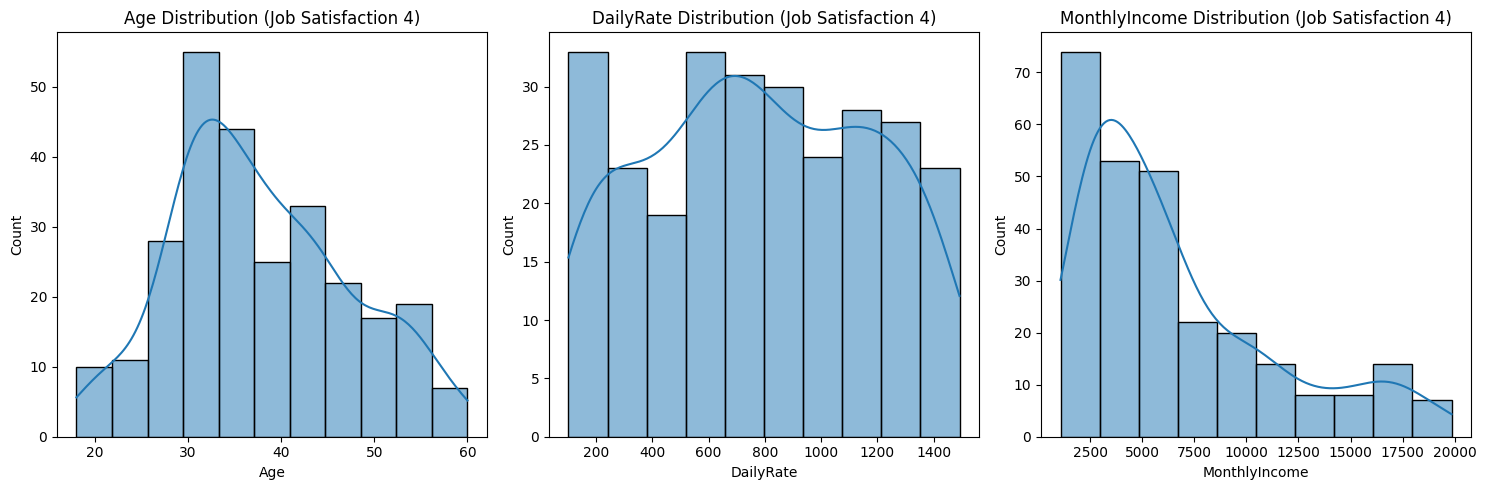

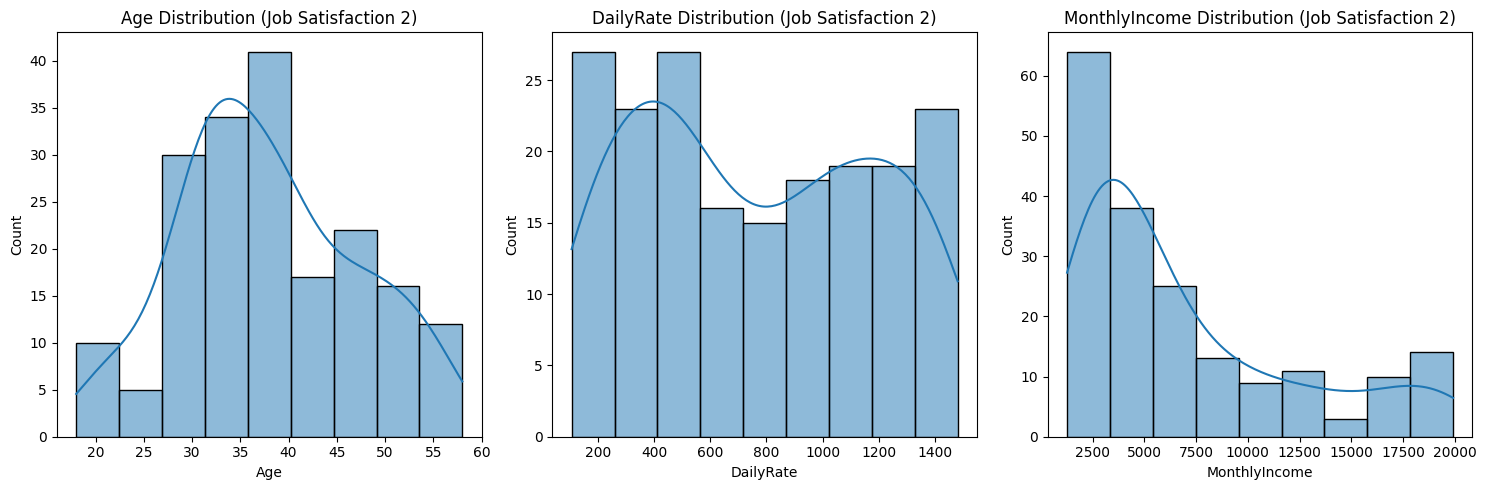

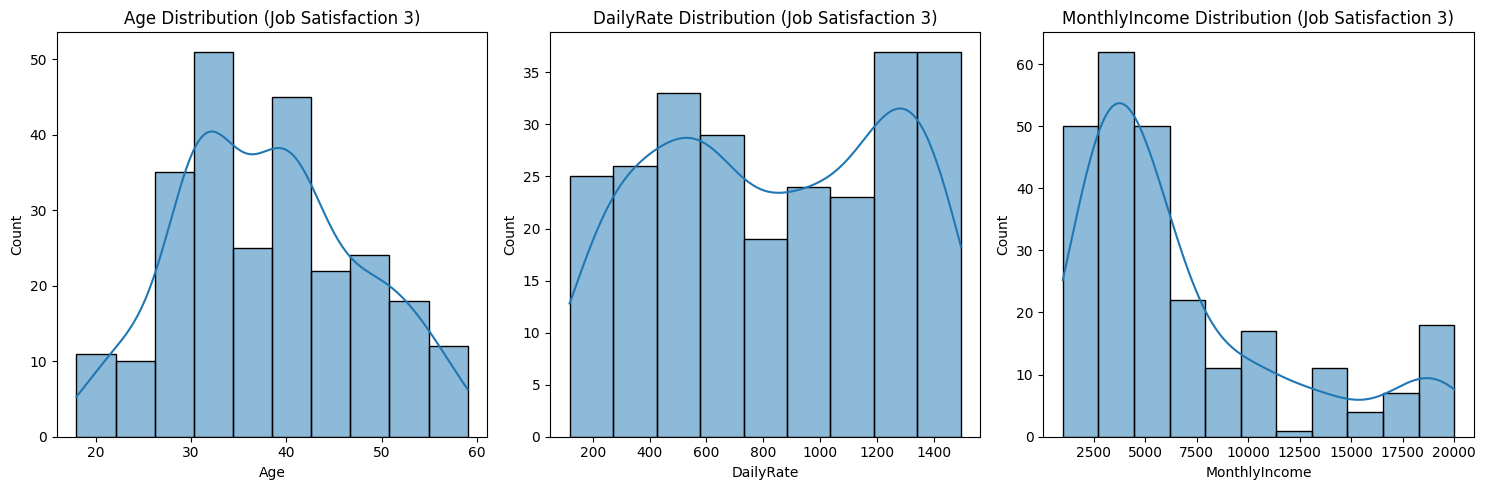

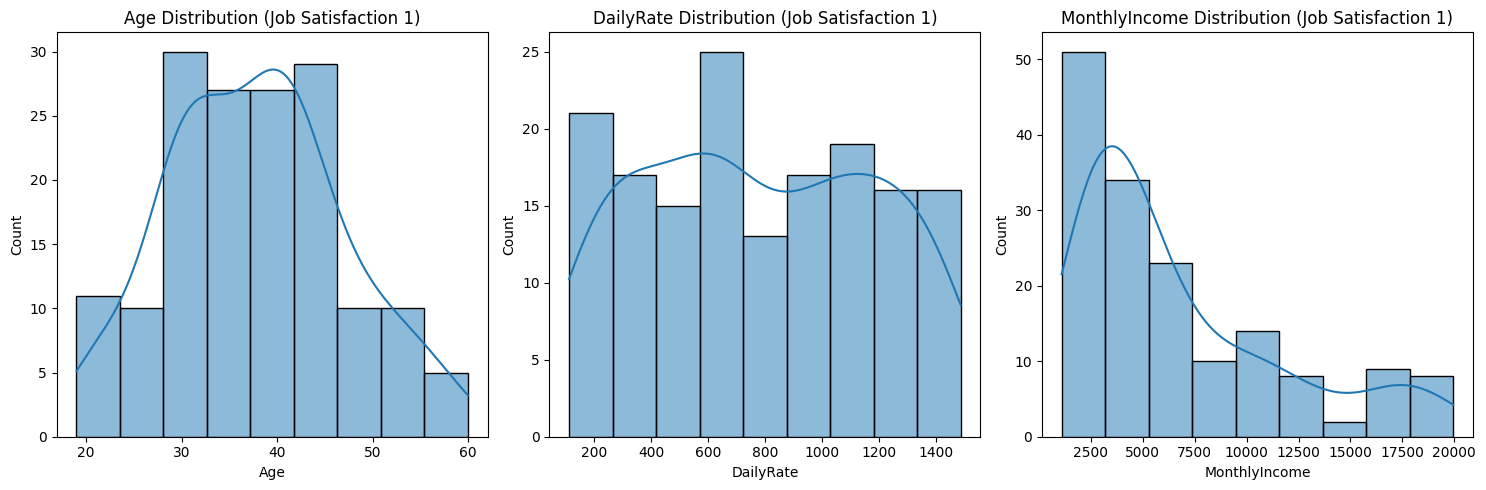

In [21]:
#Plotting to check for normality visually

for level in job_satisfaction_levels:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot Age
    sns.histplot(employee_df[employee_df['JobSatisfaction'] == level]['Age'], ax=axes[0], kde=True)
    axes[0].set_title(f'Age Distribution (Job Satisfaction {level})')

    # Plot DailyRate
    sns.histplot(employee_df[employee_df['JobSatisfaction'] == level]['DailyRate'], ax=axes[1], kde=True)
    axes[1].set_title(f'DailyRate Distribution (Job Satisfaction {level})')

    # Plot MonthlyIncome
    sns.histplot(employee_df[employee_df['JobSatisfaction'] == level]['MonthlyIncome'], ax=axes[2], kde=True)
    axes[2].set_title(f'MonthlyIncome Distribution (Job Satisfaction {level})')

    plt.tight_layout()
    plt.show()

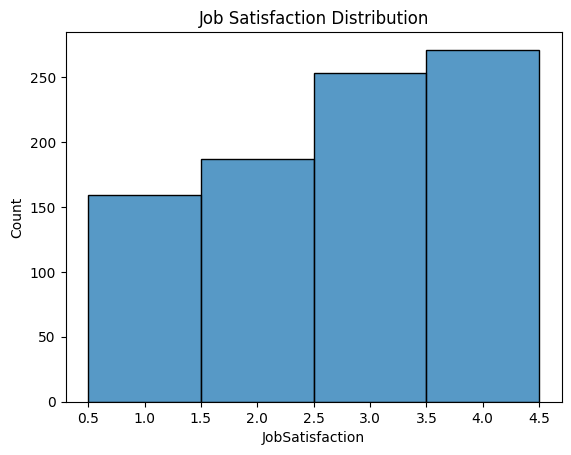

In [25]:
#plotting Job satisfcation

sns.histplot(employee_df['JobSatisfaction'])
plt.title('Job Satisfaction Distribution')
plt.show()

For all job satisfaction levels, DailyRate and MonthlyIncome do not follow a normal distribution (p-values < 0.05). For Age, only JobSatisfaction level 1 shows a p-value above 0.05, suggesting normality at this level. For the other levels, Age does not meet the normality assumption either. Since the MANOVA test assumes multivariate normality for the dependent variables, these results suggest that the normality assumption is not fully met for this data.

**5. Homogeneity of Variance Assumption** -*The variance-covariance matrix of the dependent variables is equal across groups.*


In [35]:
#Testing for homogeneity of variance
box_m_test = pg.box_m(data=employee_df,
                       dvs=['Age', 'DailyRate', 'MonthlyIncome'],
                       group='JobSatisfaction') # Pass 'group' as a named argument or as the third positional argument

box_m_test

,Chi2,df,pval,equal_cov
box,24.975316,18.0,0.125598,True


**7. Homoscedasticity Assumption** -*variances are equal across groups*

In [36]:
from scipy.stats import levene

print("Levene's Test for Homoscedasticity")
levene_age = levene(employee_df['Age'][employee_df['JobSatisfaction'] == 1],
                    employee_df['Age'][employee_df['JobSatisfaction'] == 2],
                    employee_df['Age'][employee_df['JobSatisfaction'] == 3],
                    employee_df['Age'][employee_df['JobSatisfaction'] == 4])

levene_daily_rate = levene(employee_df['DailyRate'][employee_df['JobSatisfaction'] == 1],
                           employee_df['DailyRate'][employee_df['JobSatisfaction'] == 2],
                           employee_df['DailyRate'][employee_df['JobSatisfaction'] == 3],
                           employee_df['DailyRate'][employee_df['JobSatisfaction'] == 4])

levene_monthly_income = levene(employee_df['MonthlyIncome'][employee_df['JobSatisfaction'] == 1],
                               employee_df['MonthlyIncome'][employee_df['JobSatisfaction'] == 2],
                               employee_df['MonthlyIncome'][employee_df['JobSatisfaction'] == 3],
                               employee_df['MonthlyIncome'][employee_df['JobSatisfaction'] == 4])

print("AGE:", levene_age)
print("DAILY_RATE:", levene_daily_rate)
print("MONTHLY_INCOME:", levene_monthly_income)

Levene's Test for Homoscedasticity
AGE: LeveneResult(statistic=0.13531528485476843, pvalue=0.9389826395928927)
DAILY_RATE: LeveneResult(statistic=1.2822834780719896, pvalue=0.27920506060706185)
MONTHLY_INCOME: LeveneResult(statistic=0.6030985495616467, pvalue=0.613097612687869)


The Levene's Test shows for all of the dependent variables, the p-values are all above 0.05. This suggests homoscedasticity which satisfies this assumption.

**Implemenation of MANOVA**

Since the assumption for normality was not met, we will consider using a non-parametric MANOVA test-- PERMANOVA. We will fit both MANOVA and PERMANOVA to observe the differences considering the non-satisfaction of the Normality test.

In [40]:
# Define dependent variables and independent variable
dependent_vars = 'Age + DailyRate + MonthlyIncome'
independent_var = 'JobSatisfaction'

# Fit MANOVA
manova = MANOVA.from_formula(f'{dependent_vars} ~ {independent_var}', data=employee_df)
manova_results = manova.mv_test()
print("MANOVA Results:")
print(manova_results)

MANOVA Results:
                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept        Value  Num DF  Den DF   F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.2129 3.0000 864.0000 1064.9733 0.0000
         Pillai's trace 0.7871 3.0000 864.0000 1064.9733 0.0000
 Hotelling-Lawley trace 3.6978 3.0000 864.0000 1064.9733 0.0000
    Roy's greatest root 3.6978 3.0000 864.0000 1064.9733 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
     JobSatisfaction     Value  Num DF   Den DF  F Value Pr > F
---------------------------------------------------------------
           Wilks' lambda 0.9926 9.0000 2102.8996  0.7144 0.6962
          Pillai's trace 0.0074 9.0000 2598

In [56]:
# Define the matrix for PERMANOVA and groups for comparison
data_matrix = employee_df[['Age', 'DailyRate', 'MonthlyIncome']].to_numpy()
ids = employee_df.index.astype(str)  # Unique identifiers based on the index
distance_matrix = DistanceMatrix.from_iterable(data_matrix, lambda x, y: np.linalg.norm(x - y))
groups = employee_df['JobSatisfaction'].values

# Step 3: Apply PERMANOVA
permanova_results = permanova(distance_matrix, grouping=groups)
print("PERMANOVA Results:")
print(permanova_results)

PERMANOVA Results:
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     870
number of groups                  4
test statistic             0.183618
p-value                        0.93
number of permutations          999
Name: PERMANOVA results, dtype: object


**Analysis**

**1.  Do different levels of job satisfaction affect employees’ age, daily rate, and monthly income?**

>The MANOVA results show no significant effect of JobSatisfaction on the combined dependent variables `(Age, DailyRate, and MonthlyIncome)`. This is indicated by a high `p-value (0.6962)` across the multivariate tests (Wilks' lambda, Pillai's trace, Hotelling-Lawley trace, and Roy's greatest root), suggesting that variations in job satisfaction do not have a statistically significant impact on age, daily rate, or monthly income when considered collectively.
Similarly, the PERMANOVA test also indicates a non-significant relationship with a `p-value of 0.93`, supporting the conclusion that job satisfaction levels do not significantly affect these variables.

**2. Is there a significant difference in age across different job satisfaction levels?**

>No, based on the MANOVA results, age does not significantly differ across job satisfaction levels. The non-significant MANOVA and PERMANOVA p-values imply that `JobSatisfaction` levels do not have a significant effect on age.

**3. Is there a significant difference in daily rate across different job satisfaction levels?**

> Similarly, there is no significant difference in `DailyRate` across different job satisfaction levels. Both the MANOVA and PERMANOVA results indicate that daily rate is not significantly impacted by job satisfaction.

**4. Is there a significant difference in monthly income across different job satisfaction levels?**

>No, `MonthlyIncome` does not vary significantly with job satisfaction levels, as shown by the MANOVA and PERMANOVA results. The p-values suggest that there is no statistically meaningful difference in monthly income when grouped by job satisfaction.

**5. Which of the dependent variable `(age, daily rate, or monthly income)` contributes most to the differences between job satisfaction levels?**

>None of the dependent variables `Age, DailyRate, or MonthlyIncome` show a significant contribution to differences between job satisfaction levels. This can be observed from the non-significant MANOVA results, which indicate no substantial differences across the levels of job satisfaction.

**6. Are there any interactions or patterns in the relationships between age, daily rate, and monthly income when grouped by job satisfaction levels?**

>The lack of significant results in both the MANOVA and PERMANOVA analyses suggests that there are no meaningful interactions or patterns among `Age, DailyRate, and MonthlyIncome` based on `job satisfaction levels`. This implies that job satisfaction does not introduce any distinct interaction or pattern between these variables.